In [1]:
# Import the packages for experiment
import warnings

warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import random
import keras

from itertools import product
from joblib import Parallel, delayed

# Random Classification Experiment

This experiment will use images from the **CIFAR 100** database (https://www.cs.toronto.edu/~kriz/cifar.html) and showcase the classification efficiency of algorithms in the **Progressive Learning** project (https://github.com/neurodata/progressive-learning).

## Progressive Learning

The Progressive Learning project aims to improve program performance on sequentially learned tasks, proposing a lifelong learning approach.

It contains two different algorithms: **Lifelong Learning Forests** (**L2F**) and **Lifelong Learning Network** (**L2N**). **L2F** uses Uncertainy Forest as transformers, while **L2N** uses deep networks. These two algorithms achieve both forward knowledge transfer and backward knowledge transfer, and this experiment is designed to cover the **L2F** model.

### Choosing hyperparameters

The hyperparameters here are used for determining how the experiment will run.

In [2]:
### MAIN HYPERPARAMS ###
num_points_per_task = 500
shift_num = 6
task_num = 20
tree_num = 10
########################

### Loading datasets

The CIFAR 100 database contains 100 classes of 600 images, each separating into 500 training images and 100 testing images.

In [3]:
# load image datasets from the CIFAR-100 database
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

# modify data shapes for specific model
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape(
    (data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3])
)
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

### Running experiment

The following codes will run multiple experiments in parallel. For each experiment, we have task_num number of tasks. For each task, we randomly select 10 classes of the classes to train on. As we will observe below, each task increases Backwards Transfer Efficiency (BTE) with respect to Task 1 (Task 1 being the first task corresponding to 10 randomly selected classes).

In [4]:
from functions.random_class_functions import run_parallel_exp

slot_num = int(5000/num_points_per_task)
slot_fold = range(slot_num)
shift_fold = range(1, shift_num + 1, 1)

# run the L2F model
n_trees = [tree_num]
iterable = product(n_trees, shift_fold, slot_fold)
df_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(run_parallel_exp)(
        data_x, data_y, ntree, num_points_per_task, task_num, slot=slot, shift=shift
    )
    for ntree, shift, slot in iterable
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 73.8min finished


### Plotting backward transfer efficiency

Backward transfer efficiency (BTE) measures the relative effect of future task data on the performance on a certain task.

\begin{align}
BTE^t(f_n):= E[R^t(f_n^{<t}) / R^t(f_n)] 
\end{align}

It is the expected ratio of two risk functions of the learned hypothesis, one with access to the data up to and including the last observation from task t, and the other with access to the entire data sequence. The codes below uses the experiment results to calculate the average BTE numbers and display their changes over tasks learned.

In [5]:
from functions.random_class_functions import calculate_results

# obtain bte results
btes = calculate_results(df_results, slot_num, shift_num)

# calculate the average numbers
bte = np.mean(btes, axis=0)

# setting plot parameters
fontsize = 22
ticksize = 20

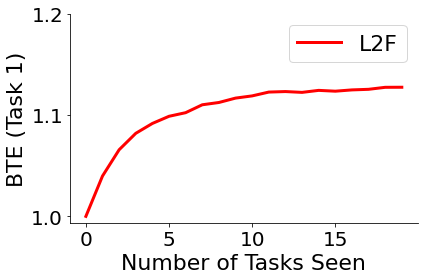

In [6]:
from functions.random_class_functions import plot_bte
    
plot_bte(bte, fontsize, ticksize)